# SIMULATION ANALYSIS

Molecular Dynamics (MD) are more and more routinely and effortlessly performed using a plethora of different engines, each optimised for a specific purpose. Examples of these MD engines are GROMACS, NAMD, LAMMPS, DESMOND, AMBER etc.

While setting up and running a MD simulation is still a non-trivial task, more and more importance is devoted to the process of trajectory analysis. With the current impressive hardware and software developments we can *generate* huge amount of trajectory data and it is crucial to design robust analysis pipelines to **make sense of the data**.

The instruments we are looking for should be:
- **reliable**, i.e. widely tested;
- **complete**: it is not recommended to analyse data employing a set of tools coming from a bunch of heterogeneous sources;
- **suitable for large-scale analysis**
- **suitable for quick and dirty scripting**

# MDANALYSIS


In this tutorial we will introduce you to **[MDAnalysis](https://www.mdanalysis.org/)**, a collaborative python package for molecular dynamics data analysis. Although MDAnalysis is easy to learn and custom, it has a good performance since its routines interface with C codes, especially in the case of computationally expensive tasks. Indeed, one of the main aims of the project is to provide the user with all the data about the system stored in numpy arrays, which can be easily manipulated by the fast python libraries such as *numpy*, *scipy* and *scikit-learn*. 

When in doubt, we encourage you to check out the [user guide](https://userguide.mdanalysis.org/1.0.0/index.html).

For visualization we will use **[nglview](https://github.com/nglviewer/nglview)**, a widget for jupyter notebook. This is very useful for interactive work. Check the [github page](https://github.com/nglviewer/nglview) for the documentation and examples.

In [84]:
import MDAnalysis as mda
print(mda.__version__)
from pathlib import Path
from os import fspath
import nglview
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd

1.0.1


## Object-oriented software
MDAnalysis is strongly object-oriented. Every object possesses a set of properties, called **attributes** and a set of **procedures** (or **methods**).

Which are the objects in the realm of molecular simulations?

- Atoms
- Groups of Atoms
- Trajectories
- Topology objects
- many more

Each of these elements is an object in MDAnalysis, with its methods and attributes.

## The fundamental object: the Universe
The core object *Universe* contains all the information we possess about the system. Typically we consider a topology and a trajectory file.

Here we will load two sample files, a *PSF* topology file and a *DCD* trajectory file referring to a short trajectory of the Adenylate Kinase enzyme. MDAnalysis supports several different [file formats](https://docs.mdanalysis.org/stable/documentation_pages/coordinates/init.html#id2) produced by the currently most used MD engines.

When a universe is initialized, the topology (trajectory) is read by a *TopologyReader* (*TrajectoryReader*) object. Frames in the trajectory are splitted in several Timesteps objects.

In [2]:
simdir = Path('./data/')
PSF = simdir / 'adk4AKE.psf'
eqDCD = simdir / 'adk_npt_200.dcd'
PDB = simdir / 'adk_open.pdb'
cl_PDB = simdir / 'adk_closed.pdb'

In [3]:
universe = mda.Universe(str(PSF),str(eqDCD))

In [119]:
view = nglview.show_mdanalysis(universe)
view

NGLWidget(max_frame=200)

## 1. Basic ingredients
- AtomGroups 
- Topology
- Trajectory
- Selections

## 1.1 The trajectory and the Timesteps

The Trajectory is a collection of Timesteps, the latter representing all the available information we have about a single time frame. One tricky point in MDAnalysis is the fact that it is easier to iterate **implicitly** over the timesteps rather than cycling **explicitly**, as one may expect. Indeed, a trajectory in the Universe possesses an attribute called **ts** that defines which Timestep object we are considering. Every time we iterate over this attribute we change our position in time. 

####  Implicit iteration

In [4]:
# here we are at timestep 0
universe.trajectory.ts

< Timestep 0 with unit cell dimensions [99.683105 99.683105 99.683105 90.       90.       90.      ] >

We can easily access the coordinates corresponding to the current timestep

In [5]:
universe.trajectory.ts.positions

array([[41.149998, 32.739998, 53.61    ],
       [41.63    , 32.47    , 54.45    ],
       [40.43    , 33.41    , 53.850002],
       ...,
       [40.72    , 30.03    , 43.239998],
       [40.079998, 29.22    , 43.969997],
       [40.24    , 31.02    , 42.61    ]], dtype=float32)

We can switch to the next step:

In [6]:
universe.trajectory.next()
universe.trajectory.ts

< Timestep 1 with unit cell dimensions [99.79879 99.79879 99.79879 90.      90.      90.     ] >

which has its own coordinates vector

In [7]:
universe.trajectory.ts.positions

array([[41.340004, 32.79    , 52.79    ],
       [40.620003, 33.48    , 52.940002],
       [40.940002, 32.11    , 52.15    ],
       ...,
       [47.000004, 27.870003, 44.4     ],
       [46.190002, 26.970001, 44.440002],
       [47.550003, 28.290003, 45.45    ]], dtype=float32)

The typical usage of MDAnalysis consists on the iteration of an analysis protocol over all the available frames of a trajectory.

#### Explicit iteration

It is possible to explicitly access the different Timesteps of the trajectory.

In [8]:
universe.trajectory[0].positions

array([[41.149998, 32.739998, 53.61    ],
       [41.63    , 32.47    , 54.45    ],
       [40.43    , 33.41    , 53.850002],
       ...,
       [40.72    , 30.03    , 43.239998],
       [40.079998, 29.22    , 43.969997],
       [40.24    , 31.02    , 42.61    ]], dtype=float32)

In [9]:
universe.trajectory[1].positions

array([[41.340004, 32.79    , 52.79    ],
       [40.620003, 33.48    , 52.940002],
       [40.940002, 32.11    , 52.15    ],
       ...,
       [47.000004, 27.870003, 44.4     ],
       [46.190002, 26.970001, 44.440002],
       [47.550003, 28.290003, 45.45    ]], dtype=float32)

## 1.2 AtomGroups
The Universe contains a set of atoms that will be employed throughout the analysis. Let's see who they are.

In [10]:
universe.atoms

<AtomGroup with 3341 atoms>

Here we meet the object *AtomGroup*, that allows to lump several atoms in a single structure. This class contains many useful attibutes:

- ```natoms```, ```n_residues```, ```n_fragments```, ```n_segments``` : they describe how many of these entities are present in the AtomGroup;
- ```positions```, ```velocities```, ```forces``` , ```dimensions```: all the attributes of the Timestep object are inherited by this class;
- ```bonds```, ```angles```, ```dihedrals``` and other elements of the Topology.

You can easily access the possible attributes of the AtomGroup with tab completion:

In [20]:
universe.atoms.

SyntaxError: invalid syntax (<ipython-input-20-ea91ba5e6823>, line 1)

In [21]:
universe.atoms.velocities

NoDataError: This Timestep has no velocities

Guess what? The AtomGroup is composed by a series of *Atom* objects! 

In [7]:
universe.atoms[0]

<Atom 1: N of type NH3 of resname MET, resid 1 and segid ADK>

From the *Atom* object you can easily access any possible detail about the atom you are interested in.

In [8]:
print("residue id of atom ", universe.atoms[0], " is ", universe.atoms[0].resid)
print("residue name of atom ", universe.atoms[0], " is ", universe.atoms[0].resname)
print("partial charge of atom ", universe.atoms[0], " is ", universe.atoms[0].charge)
print("position of atom ", universe.atoms[0], " is ", universe.atoms[0].position)

residue id of atom  <Atom 1: N of type NH3 of resname MET, resid 1 and segid ADK>  is  1
residue name of atom  <Atom 1: N of type NH3 of resname MET, resid 1 and segid ADK>  is  MET
partial charge of atom  <Atom 1: N of type NH3 of resname MET, resid 1 and segid ADK>  is  -0.30000001192092896
position of atom  <Atom 1: N of type NH3 of resname MET, resid 1 and segid ADK>  is  [41.340004 32.79     52.79    ]


#### Question 1
can you guess why the *position* attribute of each atom concerns the second Frame of the trajectory?

## 1.3 Atom Selection

The AtomGroup automatically defined by the creation of the Universe contains all the atoms present in the topology. Obviously it is not the only group that you can define.

The user can create your own AtomGroup with the **```select_atoms```** method of a Universe/AtomGroup. The syntax is very similar to that of CHARMM selection commands.

### 1.3.1 keywords-based selections
Keywords are case-sensitive strings that are recognized by the *SelectionParser*, which outputs a list of atoms ordered according to the sequence of atoms in the Universe. 

Useful examples of simple selections are:
- simple keywords: ```"backbone"```, ```"protein"```, ```"nucleic"```, ```"water"```
- topology-based keyworkds: ```resname MET```, ```name CA```, ```"resnum 13:16"```
- pattern matching keywords: ```"resname HS?"```, ```"resname G*"```, ```"resnum 2[0-1]"```

In [17]:
bkb_group = universe.select_atoms("backbone")
print("backbone group\n", bkb_group)
cb_group = universe.select_atoms("name CB")
print("\ncb_group\n",cb_group)
resname_group = universe.select_atoms("resname G*")
print("\nresname_group\n", resname_group)

backbone group
 <AtomGroup [<Atom 1: N of type NH3 of resname MET, resid 1 and segid ADK>, <Atom 5: CA of type CT1 of resname MET, resid 1 and segid ADK>, <Atom 18: C of type C of resname MET, resid 1 and segid ADK>, ..., <Atom 3334: C of type CC of resname GLY, resid 214 and segid ADK>, <Atom 3337: N of type NH1 of resname GLY, resid 214 and segid ADK>, <Atom 3339: CA of type CT2 of resname GLY, resid 214 and segid ADK>]>

cb_group
 <AtomGroup [<Atom 7: CB of type CT2 of resname MET, resid 1 and segid ADK>, <Atom 24: CB of type CT2 of resname ARG, resid 2 and segid ADK>, <Atom 48: CB of type CT1 of resname ILE, resid 3 and segid ADK>, ..., <Atom 3278: CB of type CT2 of resname LYS, resid 211 and segid ADK>, <Atom 3300: CB of type CT1 of resname ILE, resid 212 and segid ADK>, <Atom 3319: CB of type CT2 of resname LEU, resid 213 and segid ADK>]>

resname_group
 <AtomGroup [<Atom 120: N of type NH1 of resname GLY, resid 7 and segid ADK>, <Atom 121: HN of type H of resname GLY, resid 7 an

###  1.3.2 combining selections

multiple selection can be combined with boolean operators. 

Imagine that I want to select all the heavy (not hydrogen) atoms of a protein that do not belong to the main chain.

In [19]:
side_chain_group = universe.select_atoms("not backbone and not name H*")
print("side_chain_group\n",side_chain_group)

side_chain_group
 <AtomGroup [<Atom 7: CB of type CT2 of resname MET, resid 1 and segid ADK>, <Atom 10: CG of type CT2 of resname MET, resid 1 and segid ADK>, <Atom 13: SD of type S of resname MET, resid 1 and segid ADK>, ..., <Atom 3328: CD2 of type CT3 of resname LEU, resid 213 and segid ADK>, <Atom 3335: OT1 of type OC of resname GLY, resid 214 and segid ADK>, <Atom 3336: OT2 of type OC of resname GLY, resid 214 and segid ADK>]>


### 1.3.3 geometry-based selections

MDAnalysis supports several geometric selections, which allow to keep track of the arrangements of atoms in interesting regions of the structure. Some examples are:
- **point x y z distance**: to find all the atoms that lie closer than distance to the (x,y,z) coordinate;
- **around distance selection**: to retrieve all atoms closer than distance to another selection. For some reasons these two selections do not work properly in the current version;
- **prop [abs] property operator value**: to list all the atoms which possess a value of property (x,y or z) that match the condition defined by operator (<,>,==,>=,<=,!=) and value

In [110]:
around_selection = universe.select_atoms("not name H* and around 2.0 name CA and resid 1:2")
print("around c alpha selection\n",around_selection.atoms)

around c alpha selection
 <AtomGroup [<Atom 1: N of type NH3 of resname MET, resid 1 and segid ADK>, <Atom 7: CB of type CT2 of resname MET, resid 1 and segid ADK>, <Atom 18: C of type C of resname MET, resid 1 and segid ADK>, <Atom 20: N of type NH1 of resname ARG, resid 2 and segid ADK>, <Atom 24: CB of type CT2 of resname ARG, resid 2 and segid ADK>, <Atom 42: C of type C of resname ARG, resid 2 and segid ADK>]>


### 1.3.4 dynamic selections

While some selections remain constant over the whole trajectory, others (like geometric selections) may change as the molecule evolves.

Can we keep track of the time-evolution in our selections? With the **updating** keyword we force the software to re-calculate the selection when the Timestep is changed. 

In [11]:
# example on our protein
sel_res_128_130 = universe.select_atoms("resid 128:130")

Imagine that we want to identify all the atoms closer than 0.45 nanometers to our selection. 

In [22]:
neigh = universe.select_atoms("around 4.5 resid 128:130", updating = True)
print("atom group with ", neigh.n_atoms, " atoms in ", neigh.n_residues ," residues")
universe.trajectory.next()
print("atom group with ", neigh.n_atoms, " atoms in ", neigh.n_residues ," residues")

atom group with  56  atoms in  8  residues
atom group with  64  atoms in  6  residues


## 1.4 AtomGroup's methods
An object AtomGroup possesses a series of useful methods, such as:
- *```center_of_geometry```*
- *```center_of_mass```*
- *```moment_of_inertia```*
- *```radius_of_gyration```*

#### center of geometry

In [31]:
calpha = universe.select_atoms("name CA")
calpha.center_of_geometry(pbc=True)
# our trajectory has already been centered and PBC have been removed => 
# it is not necessary to center atoms in the primary unit cell
calpha.center_of_geometry(pbc=False)

array([49.6814042 , 49.81233881, 50.05850719])

#### center of mass

In [32]:
first_res = universe.select_atoms("not name H* and resid 1")
first_res.center_of_mass()

array([42.98378323, 33.49745358, 50.72437242])

#### moment of inertia tensor



In [33]:
first_res = universe.select_atoms("not name H* and resid 1 and backbone")
print("moment of inertia tensor of c_alpha")
calpha.moment_of_inertia()

moment of inertia tensor of c_alpha


array([[756418.32089562,  20126.61295311,   3919.05020754],
       [ 20126.61295311, 516260.40063476,  83237.07998661],
       [  3919.05020754,  83237.07998661, 572943.91141784]])

If diagonalized, it can give the principal axes of inertia of the *AtomGroup*.

In [35]:
p_axes = calpha.principal_axes(pbc=False)

#### radius of gyration

The radius of gyration is a useful measure of globularity of a structure. It is defined as the root mean square deviation of the position of the atoms with respect to the center of mass of the protein.

$R_g^{2} = \frac{1}{N} \sum_{i=1}^{N}({\bf r_i} - {\bf r_c})^2$

NB: in this approximation all the masses are assumed to be equal. In the case of heavy atoms of proteins this assumption is pretty much satisfied.

In [37]:
Rg_vector = []
for ts in universe.trajectory:
    Rg_vector.append(calpha.radius_of_gyration())

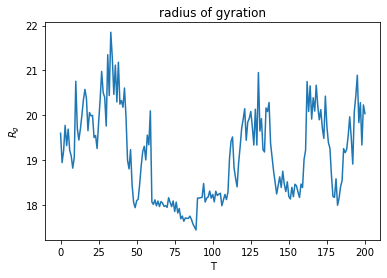

In [38]:
plt.plot(Rg_vector)
plt.title("radius of gyration")
plt.ylabel("$R_g$")
plt.xlabel("T")
plt.show()

# 2. Basic analysis

Here we will give an overview over the most popular routines that are routinely employed while analyzing MD data:

- Alignments
- RMSD and RMSF
- Native contacts
- Hydrogen bond analysis
- Ramachandran analysis
- PCA

These are only a subset of the [Analysis Modules](https://docs.mdanalysis.org/stable/documentation_pages/analysis_modules.html) embedded in MDAnalysis.

## 2.1 Root mean square deviation

- RMSD: deviations of a subset of the atoms of the structure between two different frames ($r_1$ and $r_2$) of the trajectory. One of them is called *reference frame* (for example *r1*)

- useful measure of structure similarity
 
- basically the first thing to measure when you have Molecular Dynamics data.

Considering $N$ atoms the RMSD between two structures is given by:
 
$$\text{RMSD} \ (r_1,r_2) = \sqrt{\frac{1}{N}\sum_{i=1}^{N} \delta_i^2} $$

where the indices $i$ run over the subset of selected atoms and $\delta_i$ is the deviation of atom $i$ in frame $r_2$ with respect to the position of atom $i$ in the reference frame $r_1$:

$$\delta_i^2 = |\vec{x}_{(2)i} - \vec{x}_{(1)i}|^2.$$

A rigid rototranslation has to be performed, in which frame $r_2$ is superimposed over the reference frame in order to remove unimportant translations and rotations (6 degrees of freedom to superimpose two sets of points). In this way the RMSD is minimised.

In [104]:
from MDAnalysis.analysis import align
from MDAnalysis.analysis.rms import rmsd

First, we define the reference conformation by taking 

In [106]:
ref_pdb = mda.Universe(PSF,str(PDB))
ref_pdb

<Universe with 3341 atoms>

In [107]:
view = nglview.show_mdanalysis(ref_pdb)
view

NGLWidget()

In [108]:
rmsd(universe.select_atoms('name CA').positions, ref_pdb.select_atoms('name CA').positions,superposition=True)

0.9264899111841328

In [109]:
universe_com = universe.atoms.center_of_mass()
ref_com = ref_pdb.atoms.center_of_mass()
print("universe_com = ",universe_com)
print("ref_com = ",ref_com)
universe_scaled = universe.select_atoms('name CA').positions - universe_com
ref_scaled = ref_pdb.select_atoms('name CA').positions - ref_com
R, rmsd_value = align.rotation_matrix(universe_scaled, ref_scaled)
print("rmsd = ", rmsd_value)
print("rotation matrix = \n", R)

universe_com =  [49.75378022 49.83477824 49.8365831 ]
ref_com =  [-3.72799868  9.62400822 14.35029554]
rmsd =  0.9270223919554296
rotation matrix = 
 [[ 0.99951237 -0.00990724  0.02961193]
 [-0.00931222 -0.9997533  -0.02016462]
 [ 0.0298044   0.01987903 -0.99935805]]


### 2.1.1 full trajectory alignment

We employ the *AlignTraj* class to align every Frame of a trajectory to a reference conformation.

In [110]:
alignment = align.AlignTraj(universe, ref_pdb)
alignment.run()

Text(0, 0.5, 'RMSD')

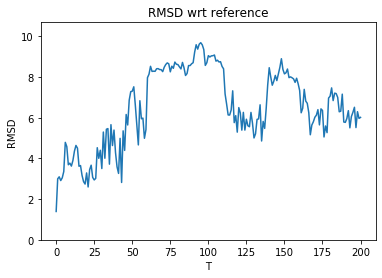

In [111]:
plt.plot(alignment.rmsd)
plt.ylim(0,max(alignment.rmsd)+1)
plt.xlabel("T")
plt.title("RMSD wrt reference")
plt.ylabel("RMSD")

### 2.1.2 full conformational matrix

We have seen how to:
- compute the RMSD between two structures
- extract the rototranslation that maximally superimpose two configurations
- align a whole trajectory to a reference frame

Now we want to build the full conformational matrix over a trajectory, namely the RMSD matrix between all pairs of frames belonging to a trajectory. Of course this task is efficiently implemented in MDAnalysis. 

In [47]:
import MDAnalysis.analysis.encore as encore

In [48]:
rmsd_matrix = encore.confdistmatrix.get_distance_matrix(universe,select='name CA').as_array()

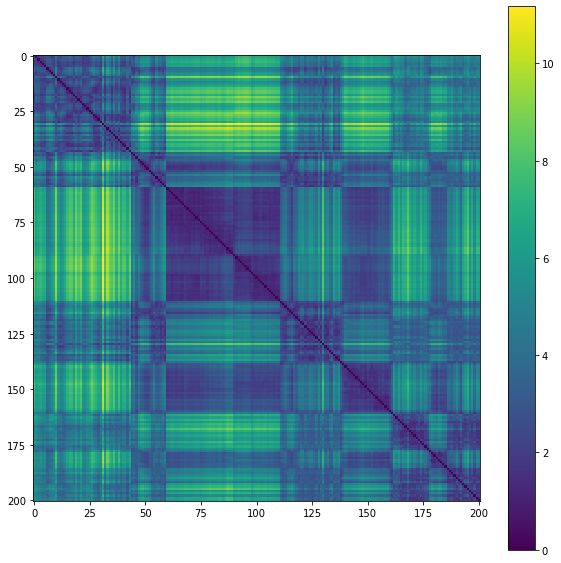

In [49]:
plt.figure(figsize=((10,10)))
plt.imshow(rmsd_matrix,cmap="viridis")
plt.colorbar()

## 2.2 Root mean square fluctuation
- measures the fluctuations of each atom with respect to the equlibrium
- proportional to the temperature ($\beta$) factor
- useful to match experimental results


$$RMSF_i = \left[\frac{1}{T}\sum_{t_j=1}^T |\mathbf{r}_i(t_j)-\mathbf{r}_i|^2\right]^{1/2}$$

Usually the reference $\mathbf{r}$ is identified with the average position of the atom over the trajectory.
<br>
As in the case of RMSD calculations, you can compute RMSF over a subset of atoms. We will stick to the $C_{\alpha}$ atoms once again.

In [35]:
from MDAnalysis.analysis.rms import RMSF

In [37]:
myRMSF = RMSF(calpha).run()

Text(0.5, 1.0, 'RMSF')

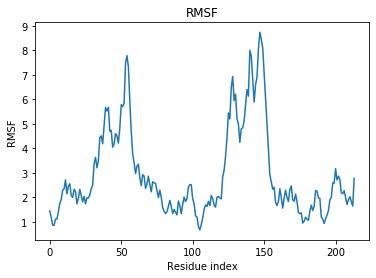

In [38]:
plt.plot(myRMSF.rmsf)
plt.xlabel('Residue index')
plt.ylabel('RMSF')
plt.title('RMSF')

Unsurprisingly, the peaks correspond to the mobile domains of the enzyme and the minima are located in correspondence of the rigid CORE domain, that acts as a hinge.

## 2.3 Native contacts analysis

A native contact is defined as a pair that are closer than a distance $r$ in the reference conformation of a biomolecule. In proteins, for instance, we refer to native contacts to those that are present in the folded configuration. Understanding the role and the formation of native contacts is a fundamental ingredient in a good analysis pipeline.

MDAnalysis provides a handy and extensible module for Native Contacts analysis. There exist three options (i.e. methods) to compute the contact matrix:
- **```hard_cut```**: in order to be counted as a contact two atoms should be at a distance equal or lower than their distance in the reference conformation;

- **```soft_cut```**: a switching function assigns different weights to different distances

$$ Q(r,r_0) = \frac{1}{1 + e^{\beta(r - \lambda r_0)}} $$

- **```radius_cut```**: two atoms form a contact if their distance is lower than a radius

In [40]:
from MDAnalysis.analysis import contacts

In [41]:
sel_calpha = "(name CA)"
start_calpha = universe.select_atoms(sel_calpha)
ca1 = contacts.Contacts(universe, select=(sel_calpha, sel_calpha), method="radius_cut",
                        refgroup=(start_calpha, start_calpha),radius=8)

In [42]:
ca1.run()

<ipython-input-43-7e27c7031058>:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


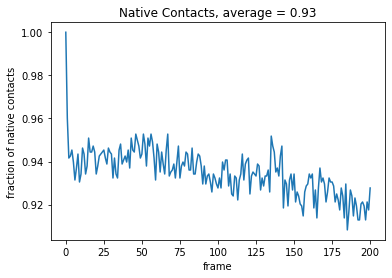

In [43]:
average_contacts = np.mean(ca1.timeseries[:, 1])
fig, ax = plt.subplots()
ax.plot(ca1.timeseries[:, 0], ca1.timeseries[:, 1])
ax.set(xlabel='frame', ylabel='fraction of native contacts',
       title='Native Contacts, average = {:.2f}'.format(average_contacts))
fig.show()

#### 2.3.1 two-dimensional native contacts analysis
It is often useful to analyse how the contact vary when changing the reference configuration. It is quite easy to perform this analysis with contacts and its built-in *q1q2* function.

<ipython-input-44-9ee4a03920f2>:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


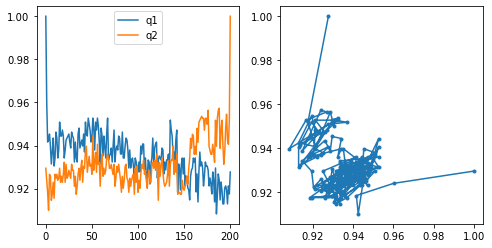

In [44]:
q1q2 = contacts.q1q2(universe, 'name CA', radius=8.0)
q1q2.run()

f, ax = plt.subplots(1, 2, figsize=plt.figaspect(0.5))
ax[0].plot(q1q2.timeseries[:, 0], q1q2.timeseries[:, 1], label='q1')
ax[0].plot(q1q2.timeseries[:, 0], q1q2.timeseries[:, 2], label='q2')
ax[0].legend(loc='best')
ax[1].plot(q1q2.timeseries[:, 1], q1q2.timeseries[:, 2], '.-')
f.show()

## 2.4 Hydrogen bond analysis
The Hydrogen Bond Analysis is a fundamental step in many simulation analysis pipelines and MDAnalysis contains a module that is dedicated to this task. The hydrogen bond network of the system is defined as an array of hydrogen bonds, each one characterised by six variables:
1. the frame in which the bond occurs
2. the donor ID
3. the ID of the hydrogen atom attached to the donor
4. the acceptor ID
5. the length of the hydrogen bond
6. the angle of the hydrogen bond (*donor-hydrogen-acceptor*)

In [45]:
from MDAnalysis.analysis.hydrogenbonds.hbond_analysis import HydrogenBondAnalysis as HBA

In [46]:
hbonds = HBA(universe=universe)
hbonds.hydrogens_sel = hbonds.guess_hydrogens("protein")
hbonds.acceptors_sel = hbonds.guess_acceptors("protein")
hbonds.run(start=0,stop=20)

In [47]:
hbonds.hbonds[0]

array([   0.        ,   19.        ,   20.        , 1578.        ,
          2.85410022,  159.29822416])

[[2009 2010 2264   18]
 [2049 2050 2264   18]
 [ 432  433 1256   17]
 ...
 [2557 2559 1738    1]
 [1135 1136 1147    1]
 [2829 2830 1435    1]]


Text(0.5, 0, 'T')

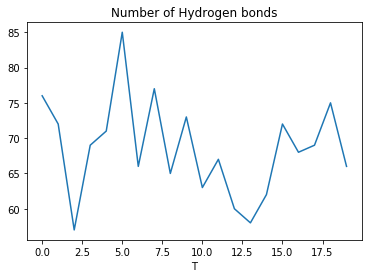

In [49]:
plt.plot(hbonds.count_by_time())
print(hbonds.count_by_ids())
plt.title('Number of Hydrogen bonds')
plt.xlabel("T")

## 2.5 Ramachandran analysis

It is possible to project the behaviour of a biomolecule a Molecular Dynamics simulation in terms of fewer observables, called collective variables.

For example, this can be done for any pair of backbone dihedral angles $(\psi,\phi)$ in a protein:

<br>
$FE (\psi,\phi) = -k_{b}T \ \ln (p(\psi,\phi))$
<br>

Let's see how the values of the dihedral angles of the catalytic residue of *Adenylate Kinase* distribute in our short sample simulation.

In [156]:
from MDAnalysis.analysis.dihedrals import Ramachandran

(201, 1, 2)


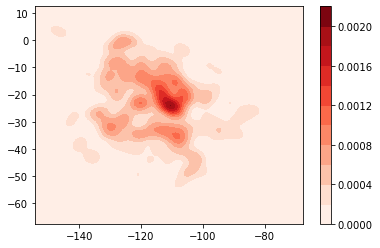

In [56]:
r = universe.select_atoms("resid 88")
R = Ramachandran(r).run()
print(R.angles.shape)
# here a single residue is selected, so two dihedrals are retrieved
sns.kdeplot(R.angles[:,0,0], R.angles[:,0,1], cmap="Reds", shade=True, bw=2,cbar=True)
plt.show()

## 2.6 PCA

The covariance matrix of a sample is defined as:

<br>
$C_{ij} := \sigma^2_{ij} = \langle(x_i - \langle x_i\rangle )\rangle\langle(x_j - \langle x_j \rangle)\rangle$
<br>

It is real and symmetric, so it is always diagonalizable. The eigenvectors of the diagonal covariance matrix are called *principal components* and form an orthonormal base. Each eigenvalues is the variance of the sample that is captured by the corresponding eigenvector.

PCA has been widely applied to Molecular Dynamics data for:
- reconstructing Free Energy landscape;
- building the Essential Dynamics subspace;
- assessing if a structure has been well equilibrated

In [86]:
import MDAnalysis.analysis.pca as pca

In [87]:
pca_analysis = pca.PCA(universe, select='name CA')
pca_analysis.run()

Our trajectory has already been aligned (on the first frame). If this is not true we could tell *pca* to align the trajectory.

In [88]:
pca_analysis = pca.PCA(universe, select='name CA',align=True)
pca_analysis.run()

each component captures a certain variance, and the components are sorted from larger to smaller variance. We can plot the _cumulated variance_ as a function of the number of components to get an idea of how many we need to explain the observed behaviour with a certain "confidence".

Text(0, 0.5, 'Fraction of cumulated variance')

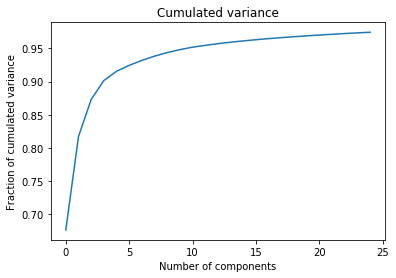

In [100]:
plt.plot(pca_analysis.cumulated_variance[:25])
plt.title("Cumulated variance")
plt.xlabel("Number of components")
plt.ylabel("Fraction of cumulated variance")

In [90]:
pca_space = pca_analysis.transform(calpha, 3)

In [91]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

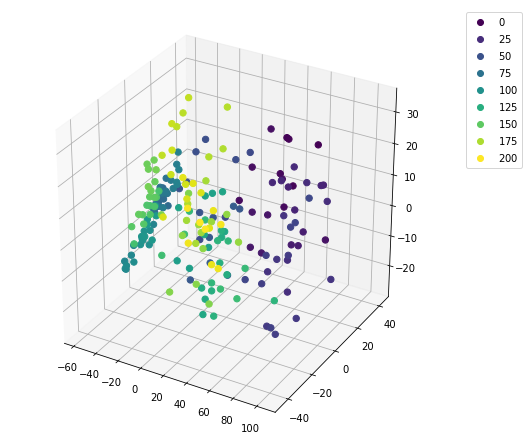

In [92]:
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)

sc = ax.scatter(pca_space[:,0], pca_space[:,1], pca_space[:,2], 
                c=np.arange(pca_space.shape[0]), s=40, marker='o', alpha=1)
# legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

## 3. Analysis building blocks
- developing analysis modules using templates

In [121]:
import MDAnalysis.analysis.base as base

### 3.1 AnalysisFromFunction

Now we will see ```AnalysisFromFunction``` the simplest of these template modules. Given a function working on one or more AtomGroups, this template converts the function in an Analysis spanning the whole trajectory.

**Example**: we want to calculate the angle between the centers of mass of the three domains of *Adenylate Kinase* over the whole trajectory. We already know from the literature (see for example [here](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4230728/)) where to place the boundaries between the domains.

First, we have to define a function that computes the angle between the domains.

In [146]:
def angle_between_domains(sel1,sel2,sel3):
    com1 = sel1.center_of_mass()
    com2 = sel2.center_of_mass()
    com3 = sel3.center_of_mass()
    #print("coms ", com1,com2,com3)
    r12 = com1 - com2
    r32 = com3 - com2
    cosine = np.dot(r12, r32) / (np.linalg.norm(r12) * np.linalg.norm(r32))
    angle = np.arccos(cosine)
    return angle

Second, we define these domains.

In [196]:
nmp = universe.select_atoms("name CA and resid 30:67")
core = universe.select_atoms("name CA and (resid 1:29 or resid 68:117 or resid 161:214)")
lid = universe.select_atoms("name CA and resid 118:160")

Third: we check that the function works

In [193]:
ang = angle_between_domains(nmp,core,lid)
print(ang)

1.5224532560248731


Fourth: we use ```AnalysisFromFunction``` to iterate over the full trajectory.

In [194]:
angle_series = base.AnalysisFromFunction(angle_between_domains,universe.trajectory,nmp,core,lid).run()

Text(0.5, 0, 'T')

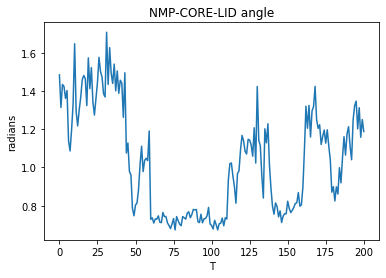

In [195]:
plt.plot(angle_series.results)
plt.title("NMP-CORE-LID angle")
plt.ylabel("radians")
plt.xlabel("T")

## TIPS AND TRICKS (15 mins)
- visualization and selection export
- other tricks

MDAnalysis allows you to [export your selection](https://docs.mdanalysis.org/stable/documentation_pages/selections_modules.html) into a variety of formats, such as *vmd* or *pymol*. Here we see a simple example of building a vmd script that denotes all the heavy atoms of *Adenylate Kinase* with a fictitious temperature factor, that can correspond to whatever property of the atoms you may want to visualize.

In [206]:
g = universe.select_atoms('resid 30:67')
g.write("nmp.vmd", name="mda_nmp")

In [82]:
g = universe.select_atoms('not name H*')
print(g.n_atoms)
probs = [1/g.n_atoms*n*np.random.rand() for n in range(g.n_atoms)]
g.atoms.tempfactors = probs
g.write("./4ake_probs_beta.pdb")

1656


#  EXERCISES & PROBLEMS

## EXERCISE 1: load a LAMMPS trajectory

## EXERCISE 2: changing the reference in RMSD calculations
The RMSD analysis showed in **2.1.1** every frame of the trajectory is compared to a conformation in the open state. Try to perform the same calculation choosing the closed pdb *adk_closed.pdb* as reference. 

Does the resulting plot look reasonable?

Try to compute the RMSD with respect to the last frame of the trajectory.

In [115]:
u_cl_ref = mda.Universe(PSF,str(cl_PDB))
alignment_cl = align.AlignTraj(universe, u_cl_ref)
alignment_cl.run()

Text(0, 0.5, 'RMSD')

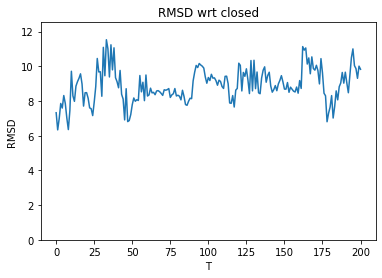

In [118]:
plt.plot(alignment_cl.rmsd)
plt.ylim(0,max(alignment_cl.rmsd)+1)
plt.xlabel("T")
plt.title("RMSD wrt closed")
plt.ylabel("RMSD")

## EXERCISE 3. bridging MD and experimental data: beta factors
The RMSF extracted in **2.2** can be compared to the experimental atomic beta factors. Do it with MDAnalysis!

*Hint*: these values are also dubbed *Temperature factors*.

In [60]:
u_op = mda.Universe(str(PDB))

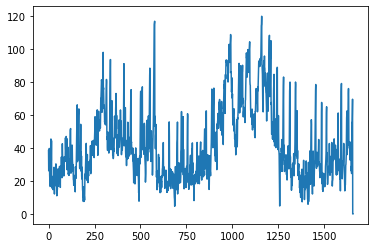

In [68]:
heavies = u_op.select_atoms("not name H*")
heavies.tempfactors
plt.plot(heavies.tempfactors)

## EXERCISE 4: a new Analysis from function

In **3.1** we calculate the angle between the domains. It is a useful measure, that allows us to discriminate between more and less compact conformations of our enzyme. However, it does not tell anything about the mutual orientation of the mobile domains. In order to estimate this variable, we have to compute the dihedral angle formed by the two mobile domains and the CORE. This is a quantity that quantifies the angle between two planes, so it is necessary to define two points on the CORE domains. A quick and easy guess for these points is represented by the residues that lie at the borders between the CORE and two external domains (residue 161 for the LID and residue 29 for the NMP).

Write a function ```dihedral_between_domains``` that computes this angle and the corresponding ```AnalysisFromFunction``` class.

*Hint*: [```MDAnalysis.lib.mdamath.dihedral```](https://docs.mdanalysis.org/1.0.0/_modules/MDAnalysis/lib/mdamath.html#dihedral) method can be quite useful when computing a dihedral angle.

In [182]:
from MDAnalysis.lib.mdamath import dihedral as compute_dihedral

In [204]:
def dihedral_between_domains(sel1,sel2,sel3,sel4):
    com1 = sel1.center_of_mass()
    com2 = sel2.center_of_mass()
    com3 = sel3.center_of_mass()
    com4 = sel4.center_of_mass()
    #compute vectors
    r12 = com2 - com1
    r32 = com3 - com2
    r43 = com4 - com3
    #compute dihedral
    dih = compute_dihedral(r12,r32,r43)
    return dih

In [200]:
core_lid = universe.select_atoms("name CA and resid 161")
core_nmp = universe.select_atoms("name CA and resid 29")
dihedral_between_domains(nmp,core_nmp,core_lid,lid)

1.9105766054323006

In [201]:
dih_series = base.AnalysisFromFunction(dihedral_between_domains,universe.trajectory,nmp,core_first,core_second,lid).run()

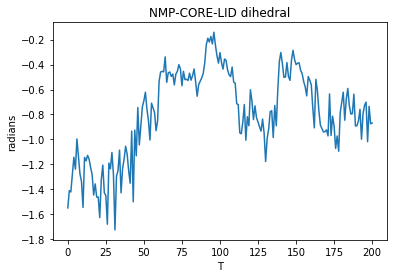

In [203]:
plt.title("NMP-CORE-LID dihedral")
plt.ylabel("radians")
plt.xlabel("T")
plt.plot(dih_series.results)